# Обучение модели классификации комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Требуется инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Нужно обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

# План

**1. Подготовка данных.**

    1.1.  Загрузка данных.
    1.2. Лемматизация текста.
    1.3. Устранение стоп-слов.

**2. Обучение.**

    2.1. Логистическая регрессия.
    2.2. LightGBM.

**3. Выводы.**

## Подготовка

In [1]:
!pip install spacy
!pip install protobuf==3.20.0

In [2]:
# импорт библиотек
import pandas as pd
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import scipy.sparse
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

### Загрузим данные

In [3]:
comments_data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
comments_data.sample(5)

,text,toxic
126790,"Please don't be condescending here, this is a ...",0
127800,Supplimentary question\nThere's a korean tilti...,0
52601,Oh boo hoo stop your damn whining!172.168.138.9,1
21361,Graeme Bartlet MUST die,1
59143,"""\n\n NPOV \n\nI wish to protest in the strong...",0


In [4]:
comments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [5]:
comments_data.duplicated().sum()

0

In [6]:
comments_data['toxic'].unique()

array([0, 1])

In [7]:
# Исследуем баланс классов
print(comments_data.loc[comments_data['toxic'] == 0, 'toxic'].count()/len(comments_data)*100)
print(comments_data.loc[comments_data['toxic'] == 1, 'toxic'].count()/len(comments_data)*100)

89.83878663084147
10.161213369158526


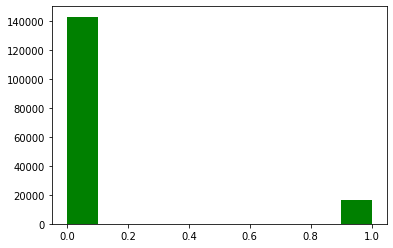

In [8]:
plt.hist(comments_data['toxic'], facecolor='green');

In [9]:
comments_data['text'] = comments_data['text'].str.lower()

Данные загрузили. Пропусков и дубликатов нет.

Присутствует сильный дисбаланс классов: прмеров с классом 0 - 90%, а с классом 1 - 10%.

### Лемматизируем текст

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [12]:
def clear_text(text):
    t = re.sub(r'[^a-zA-Z ]', ' ', text)
    t = t.split()
    t = " ".join(t)
    return t

In [13]:
%%time
lem_comments_data = comments_data['text'].apply(clear_text)
lem_comments_data.sample(5)

CPU times: user 2.04 s, sys: 6.88 ms, total: 2.04 s
Wall time: 2.05 s


75652     uh you do realize that neither excalibur nor k...
101521    thx for lol you are a steaming shocking pile o...
125424    actually it is not known commonly as revelatio...
33691     good god if this article is biased it s in fav...
120858    i don t know what that last comment means this...
Name: text, dtype: object

In [14]:
#Пример работы лемматизации
test = lem_comments_data.sample(1000).reset_index(drop=True)
test

0      good samaritan hospital thanks for the copyedi...
1                                        hi look at this
2            my hog is size soft with a nice chubb chubb
3      tad please communicate with amaury or an admin...
4      ps ie if there was no money involved would the...
                             ...                        
995    it will be really cool if someone can get the ...
996    the assertion that holodomor is a term used ex...
997    mount everest if it s a scientific fact that m...
998    i am reading it and have it watchlisted but th...
999    my edits are personal opinion what does that e...
Name: text, Length: 1000, dtype: object

In [ ]:
%%time
test = test.apply(lemmatize)
test.sample(5)

In [ ]:
%%time
lem_comments_data = lem_comments_data.apply(lemmatize)
lem_comments_data.sample(5)

Сохраним обработанные данные в файлах, чтобы не повоторять обработку каждый раз при перезапуске кода.

In [ ]:
pd.Series(lem_comments_data).to_csv('final_lem_comments_data', index = False, header=True)

### Избавимся от стоп-слов

In [10]:
lem_data = pd.read_csv('final_lem_comments_data').reset_index(drop=True)
lem_data.sample(5)

,text
135028,it say this user also use the hitchhiker s gui...
3870,when do you say if you need to message each ot...
110517,can you leave tawker this message from I I m s...
29263,unblock reason your reason here leave account ...
115692,it be badly write so no argument with its remo...


In [11]:
toxic_data = comments_data['toxic'].reset_index(drop=True)
toxic_data

0         0
1         0
2         0
3         0
4         0
         ..
159287    0
159288    0
159289    0
159290    0
159291    0
Name: toxic, Length: 159292, dtype: int64

In [12]:
lem_data['toxic'] = toxic_data
lem_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159281 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [13]:
lem_data['text'].isna().sum()

11

In [14]:
lem_data = lem_data.loc[lem_data['text'].isna() == False]
lem_data['text'].isna().sum()

0

In [15]:
features = lem_data.drop('toxic', axis=1)
target = lem_data['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345, stratify=target)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(119460, 1)
(119460,)
(39821, 1)
(39821,)


In [16]:
corpus_train = features_train['text'].values
corpus_train

array(['opps my bad bitch fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein fuck wikipedia bitch and david eppstein',
       'before you start rant about dangerous and worrisome thing you should know what you be talk about first the first section abraham form be very much form criticism form criticism be a method of biblical criticism that classifie unit of scripture by literary pattern and that attempt to trace each type to its period of oral transmission form criticism seek to determine a unit s original form and the histo

In [17]:
corpus_test = features_test['text'].values
corpus_test

array(['in addition please don t make change to verified fact in article and say in your description that the change be due to spelling and grammar fixup I m go to have to revert one of your change in the sasha grey article as it s already a resolve issue thank you cp',
       'as well as all subpage and the main userpage of my prior account user dorftrottel preferably then restore it with a simple link to this talk page',
       'there be an overlap between the function of a storage organ and a perennate organ but they be in principle different see raunki r plant life form for a classification of perennate organ resting bud be a perennate organ but not a storage organ the stem body of a cactus be generally regard as having be modify to act as a water storage organ but it s not a perennate organ in that it s not what the cactus die back to in an adverse period there could usefully be some cross referencing which I will attempt',
       ...,
       'regard joseph e prince please explain

In [18]:
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=list(stop_words), dtype=np.float32, max_features=15000)

In [19]:
tf_idf_data = count_tf_idf.fit_transform(corpus_train)
tf_idf_data

<119460x15000 sparse matrix of type '<class 'numpy.float32'>'
	with 2916069 stored elements in Compressed Sparse Row format>

In [20]:
clear_train_data = pd.DataFrame.sparse.from_spmatrix(tf_idf_data, columns=count_tf_idf.get_feature_names())
clear_train_data.sample(5)

,aa,aaliyah,aap,aardvark,aaron,ab,aba,abandon,abandonment,abbas,...,zoe,zombie,zone,zoo,zoom,zora,zoroastrian,zu,zuck,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
34123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
tf_idf_test = count_tf_idf.transform(corpus_test)
tf_idf_test

<39821x15000 sparse matrix of type '<class 'numpy.float32'>'
	with 965913 stored elements in Compressed Sparse Row format>

In [22]:
clear_test_data = pd.DataFrame.sparse.from_spmatrix(tf_idf_test, columns=count_tf_idf.get_feature_names())
clear_test_data.sample(5)

,aa,aaliyah,aap,aardvark,aaron,ab,aba,abandon,abandonment,abbas,...,zoe,zombie,zone,zoo,zoom,zora,zoroastrian,zu,zuck,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
19640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212507,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение

### Логистическая регрессия

In [23]:
log_model = LogisticRegression(random_state=12345)
log_parameters = {'C': [.01,.05,.1,.5,1,5,10], \
                  'class_weight':['balanced', None]}

grid = GridSearchCV(log_model, \
                    param_grid=log_parameters, \
                    scoring='f1', \
                    n_jobs=-1, \
                   cv=2)

features_temp = clear_train_data.sample(100).reset_index(drop=True)
target_temp = target_train.sample(100).reset_index(drop=True)

In [35]:
%%time
grid.fit(features_temp, target_temp)

CPU times: user 2min 18s, sys: 19 s, total: 2min 37s
Wall time: 2min 37s


GridSearchCV(cv=2, estimator=LogisticRegression(random_state=12345), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                         'class_weight': ['balanced', None]},
             scoring='f1')

In [24]:
%%time
grid.fit(clear_train_data, target_train)

CPU times: user 20min 28s, sys: 4min 52s, total: 25min 21s
Wall time: 25min 23s


GridSearchCV(cv=2, estimator=LogisticRegression(random_state=12345), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                         'class_weight': ['balanced', None]},
             scoring='f1')

In [25]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 10, 'class_weight': None}
0.7685681868848727


### LightGBM

In [26]:
lgbm_model = lgb.LGBMClassifier()
lgbm_parameters = {'class_weight ':['balanced', None]}

grid_lgbm = GridSearchCV(lgbm_model, \
                         param_grid=lgbm_parameters, \
                         scoring='f1', \
                         n_jobs=-1, \
                         cv=2)

In [26]:
%%time
grid_lgbm.fit(features_temp, target_temp)

[LightGBM] [Warning] Unknown parameter: balanced
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: balanced
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: balanced
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: balanced
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: balanced
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: balanced
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: balanced
[LightGBM] [Warning] Unknown parameter: class_weight
CPU times: user 41.9 s, sys: 308 ms, total: 42.2 s
Wall time: 42.2 s


GridSearchCV(cv=2, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'class_weight ': ['balanced', None],
                         'max_depth': [None, 5, 6]},
             scoring='f1')

In [27]:
print(grid_lgbm.best_params_)
print(grid_lgbm.best_score_)

{'class_weight ': 'balanced', 'max_depth': None}
0.0


In [ ]:
%%time
grid_lgbm.fit(clear_train_data, target_train)

In [27]:
predicted = grid.predict(clear_test_data)
f1 = f1_score(target_test, predicted)
f1

0.7819569364949579

## Выводы

В ходе исследования была проделана следующая работа:
1. Подготовка данных:
- Данные были проверены на наличие пропусков и дубликатов. Их не было обнаружено.
- В данных присутствует сильный дисбаланс классов: прмеров с классом 0 - 90%, а с классом 1 - 10%.
- Мы провели лемматизацию текста, сохранив результаты в промежуточный файл.
- Очистили данные от стоп-слов.
- Провели TF-IDF преобразование, с ограничением в 15 000 признаков.
2. Обучение модели:
- Мы обучили модель логической регресии, и с помощью GridSearchCV подобрали лучшие гиперпараметры: C = 10, class_weight = None. На кросс-валидации модель показала значение f1-меры равное 0.77.
3. Тестироввание модели:
- На тестовой выборке модель показала значение f1-меры равное 0.78.

Итак, нам удалось достичь значение f1-меры более 0.75.